<a href="https://colab.research.google.com/github/12jeong/Machine-Learning-with-Python-Practice/blob/master/Classification/XGB(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### XGBoost (eXtra Gradient Boost)

파이썬 래퍼 XGBoost와 사이킷런 래퍼 XGBoost의 사용상 차이점을 간략하게 요약한 글입니다



In [22]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import plot_importance

In [4]:
print(xgb.__version__)

0.90


예시) 위스콘신 유방암 데이터 세트


In [23]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


유방암 종양에 관련된 피쳐들이 있으며, 목표(target) 변수는 악성(maligant)인 경우 y=0, 양성(benign)은 y=1


In [10]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [24]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


### 1. XGBoost 고유의 프레임워크에서의 사용법 주의점

- DMatrix : "넘파이" 형태의 XGBoost만의 전용 데이터 세트, data와 label 입력 



In [25]:
dtrain = xgb.DMatrix(data=X_train, label=y_train) 
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [26]:
params = {'max_depth':3, 
          'eta':0.1,                        # XGBClassifier - learning_rate
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stoppings':100}
num_rounds = 400

In [ ]:
wlist = [(dtrain,'train'),(dtest,'evel')]
## train
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

In [32]:
## predict
pred_probs = xgb_model.predict(dtest)
print('예측 확률값')
print(np.round(pred_probs[:10],3))

preds = [1 if x>0.5 else 0 for x in pred_probs]
print(preds[:10])


예측 확률값
[0.    0.993 1.    0.999 1.    1.    1.    0.999 0.996 1.   ]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [36]:
## evaluation metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)

    roc_auc = roc_auc_score(y_test,pred_proba)
    
    print(confusion)
    print('accuracy:{0:.4f}, precision:{1:.4f}, recall:{2:.4f}, F1: {3:4f},UC:{4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

get_clf_eval(y_test, preds, pred_probs)

[[46  1]
 [ 0 67]]
accuracy:0.9912, precision:0.9853, recall:1.0000, F1: 0.992593,UC:0.9990


plot_importance() 로 피쳐중요도 시각화 툴을 제공 

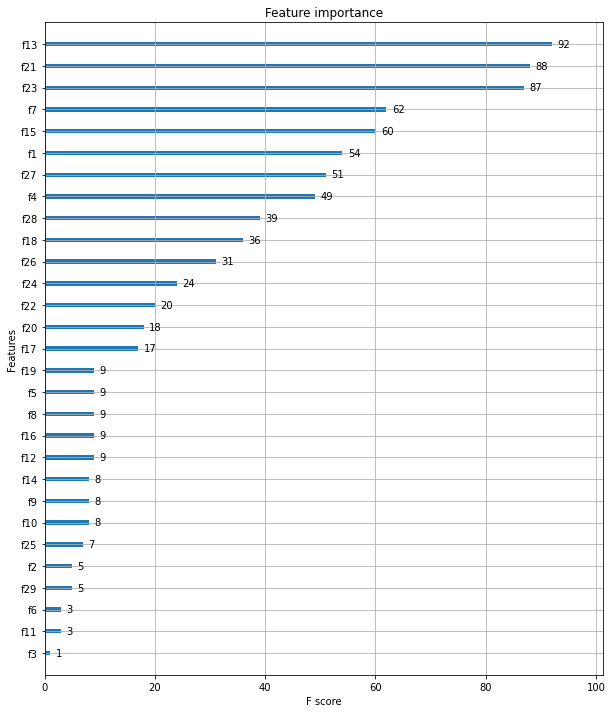

In [37]:
## visualization - feature importance
## based on "f1-score"

from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax) # numpy 기반, 피쳐명을 알 수 없음. 

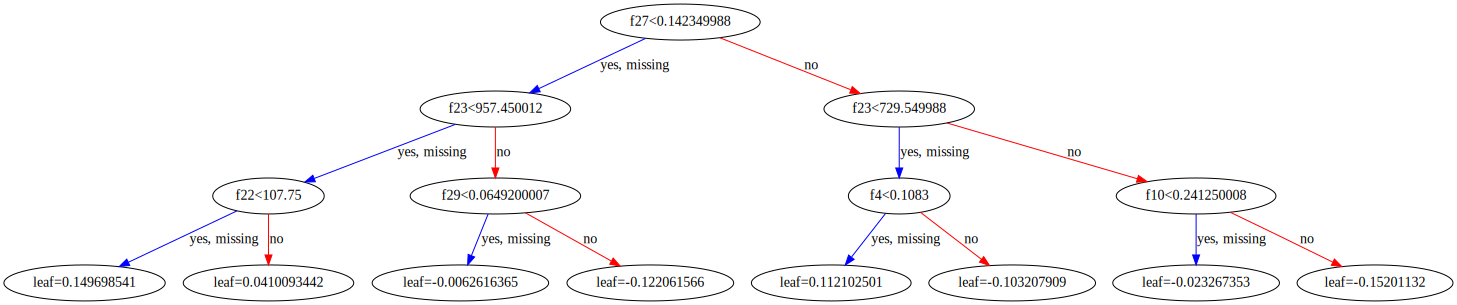

In [50]:
xgb.to_graphviz(xgb_model, num_trees=3)

### 2. XGBoost 사이킷런 래퍼 클래스

- fit(), predict() 사용 가능
- 알고리즘 클래스만 변경 가능 (**XGBClassifier, XGBRegressor**)
- eta → learning_rate
- sub_sample → subsample
- lambda → reg_lambda
- alpha → reg_alpha


In [ ]:
from xgboost import XGBClassifier 

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)] # evaluation set (temp)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)      ## train
w_preds = xgb_wrapper.predict(X_test)  ## predict
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]   ## predict (probability)

In [55]:
get_clf_eval(y_test, w_preds, w_pred_proba)

[[46  1]
 [ 0 67]]
accuracy:0.9912, precision:0.9853, recall:1.0000, F1: 0.992593,UC:0.9990


plot_importance() 똑같이 사용 가능


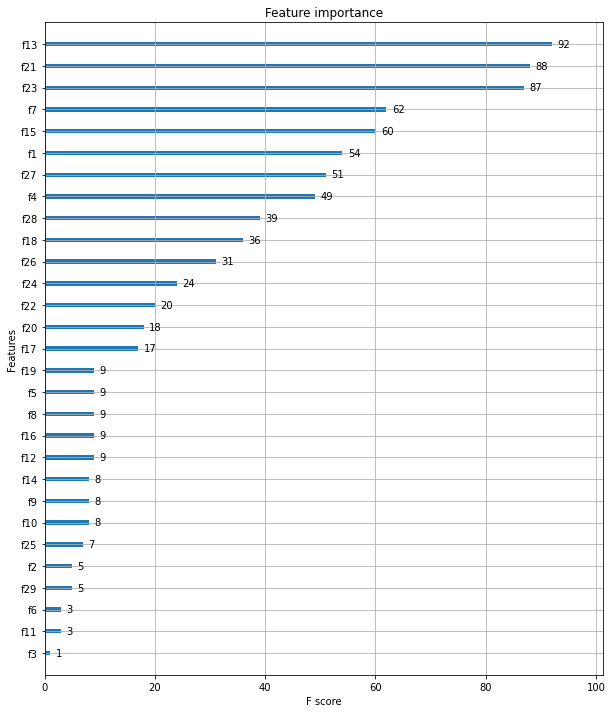

In [57]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper, ax=ax)